In [1]:
%matplotlib inline

import os
# Hide welcome message from bitsandbytes
os.environ.update({"BITSANDBYTES_NOWELCOME": "1"})

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from lib.sgm import AutoencoderKL
from lib.utils import load_torch_file, load_model_weights
from pathlib import Path    
from omegaconf import OmegaConf

yaml_file = Path("lib/model_configs/sd_xl_base.yaml")
model_params = OmegaConf.load(yaml_file).model.params        
first_stage_model = AutoencoderKL(**model_params.first_stage_config.params)
state_dict = load_torch_file("/notebooks/ComfyUI/models/checkpoints/sd_xl_base_0.9.safetensors")

class WeightsLoader(torch.nn.Module):
    pass
        
w = WeightsLoader()
w.first_stage_model = first_stage_model
_ = load_model_weights(w, state_dict)


bin /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so


2023-07-09 16:53:24.789649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


torch.Size([1, 3, 1024, 1024])
tensor(0.3487, device='cuda:0') tensor(False, device='cuda:0')


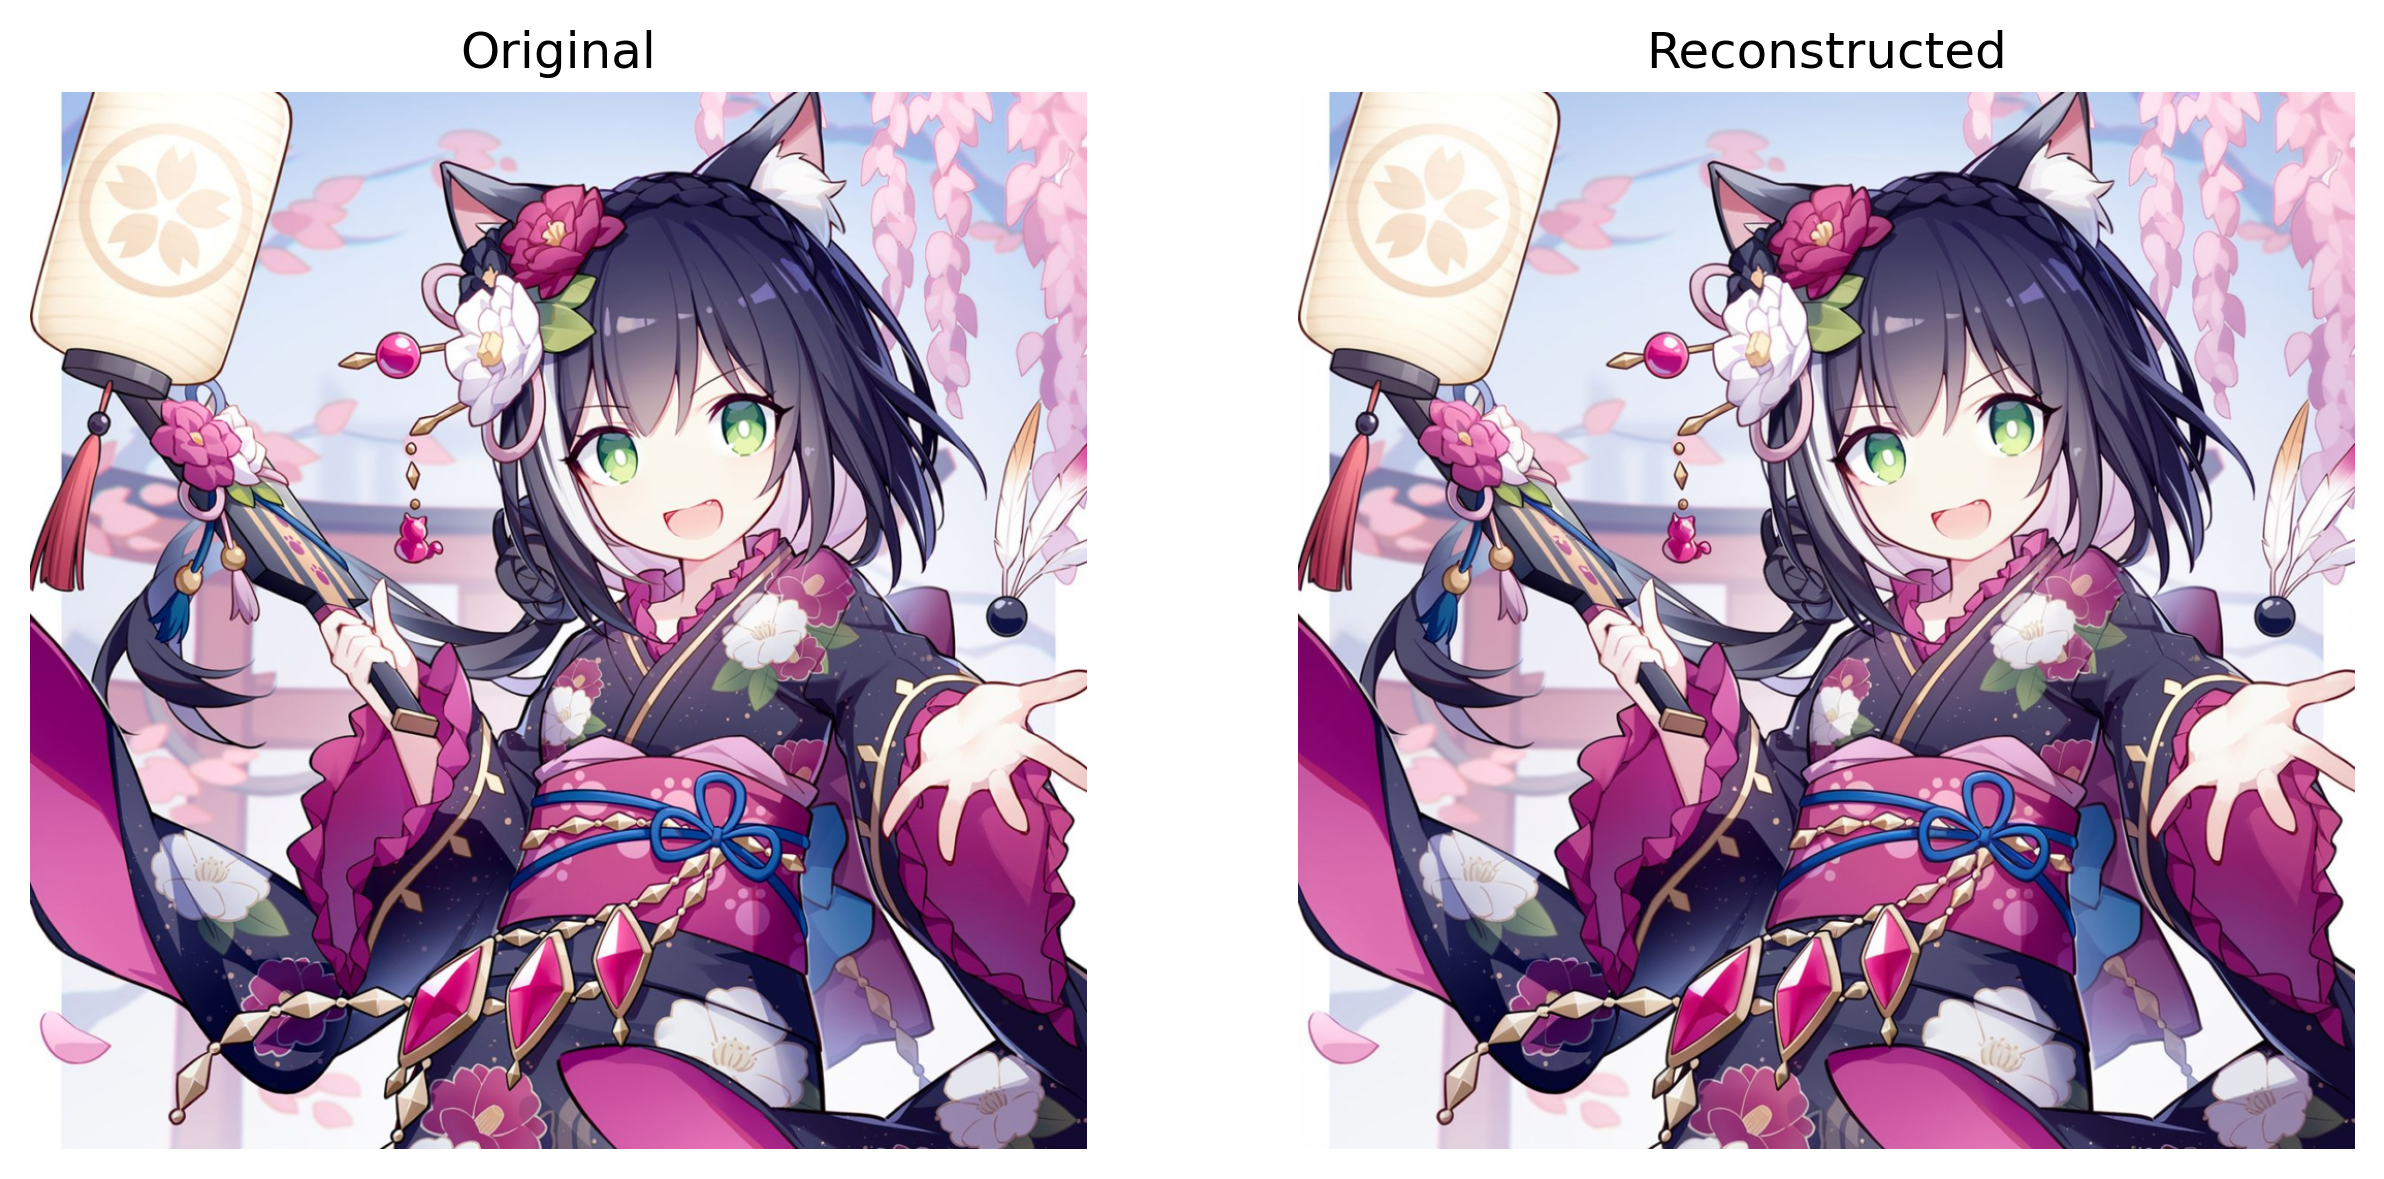

In [7]:
def load_and_preprocess_image(image_path):
    # load image with PIL
    img = Image.open(image_path)
    
    # apply transformations: resize and normalization
    transform = transforms.Compose([
        transforms.Resize(1024), # resize image
        transforms.ToTensor(),         # convert to tensor
        transforms.Normalize(mean=0.5, std=0.5)  # normalization
    ])
    
    return transform(img).unsqueeze(0)  # create a mini-batch as expected by the model

def denormalize(img, mean=0.5, std=0.5):
    res = transforms.Normalize((-1*mean/std), (1.0/std))(img)
    res = torch.clamp(res, 0, 1)
    return res

# Load and preprocess image
image_path = "/notebooks/storage/datasets/quan/009_95190271_p0_.jpg"  # change this to your image file path
img_tensor = load_and_preprocess_image(image_path).cuda()
print(img_tensor.shape)

# Load the model
# vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").cuda()
vae = first_stage_model
vae.eval().cuda()
vae.training = False

# Inference
with torch.no_grad():
    # img_encoded = vae.encode(img_tensor).latent_dist.sample()
    # img_decoded = vae.decode(img_encoded).sample
    img_encoded = vae.encode(img_tensor).sample()
    print(img_encoded.mean(), torch.isnan(img_encoded).any())
    img_decoded = vae.decode(img_encoded)

# Convert tensors to numpy arrays for visualization
img_tensor = denormalize(img_tensor).squeeze().permute(1, 2, 0).cpu().numpy()
img_decoded = denormalize(img_decoded).squeeze().permute(1, 2, 0).cpu().numpy()

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300)
axes[0].imshow(img_tensor)
axes[0].set_axis_off()  # turn off the axis
axes[0].title.set_text('Original')
axes[1].imshow(img_decoded)
axes[1].set_axis_off()  # turn off the axis
axes[1].title.set_text('Reconstructed')
plt.show()